In [1]:
# --- Parámetros (se pueden sobreescribir en CI) ---
RUN_DATE = "2025-09-15"
SEASON   = "2025_26"
MATCHDAY = None
MODEL_VERSION = "xgb-local"

# --- Rutas coherentes local/CI ---
from pathlib import Path
ROOT   = Path.cwd()
DATA   = ROOT / "data"
RAW    = DATA / "01_raw"
PROC   = DATA / "02_processed"
FEAT   = DATA / "03_features"
MODELS = DATA / "04_models"
OUT    = ROOT / "outputs"

for p in [RAW, PROC, FEAT, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibilidad
import random, numpy as np
random.seed(42); np.random.seed(42)

In [2]:
import pandas as pd, json

def load_feat(name: str):
    return pd.read_parquet(FEAT / name)

def save_model(obj, name: str):
    from joblib import dump
    MODELS.mkdir(parents=True, exist_ok=True)
    dump(obj, MODELS / name)

def save_predictions(df: pd.DataFrame, name: str = "predictions_next.csv"):
    OUT.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT / name, index=False)

def save_json(obj, name: str = "metrics_overview.json"):
    OUT.mkdir(parents=True, exist_ok=True)
    with open(OUT / name, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# **MODELOS**

In [3]:
import json
from collections import defaultdict
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# **PREDICCIÓN: Logistic Regression multinomial**

In [4]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

print("Leído:", IN_PATH, "· filas=", len(df), "· cols=", df.shape[1])
df.head(2)

Leído: /content/data/03_features/df_final.parquet · filas= 7271 · cols= 72


,B365A,B365D,B365H,Date,FTR,h_elo,a_elo,Season,home_avg_shots_last10,home_avg_shotsontarget_last10,...,a_squad_size_prev_season,a_pct_foreigners_prev_season,has_xg_data,target,home_playstyle_defensivo,home_playstyle_equilibrado,home_playstyle_ofensivo,away_playstyle_defensivo,away_playstyle_equilibrado,away_playstyle_ofensivo
0,6.00,3.6,1.57,2006-08-26,H,1857.375122,1726.076904,2006,11.2,4.9,...,33.0,24.24,0,2.0,False,False,True,True,False,False
1,3.75,3.2,2.00,2006-08-27,D,1755.359253,1701.137573,2006,10.5,3.4,...,31.0,22.58,0,1.0,False,True,False,False,True,False


Sin SMOTE:

In [5]:
# =========================
# PREDICCIÓN (BASELINE, sin SMOTE) + B365 + export
# =========================

# --- Parámetros del rango a predecir ---
PRED_SEASON = 2025
start_date  = pd.to_datetime("2025-09-19").date()
end_date    = pd.to_datetime("2025-09-21").date()

# --- Normaliza fechas y carga df_old con nombres ---
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date

IN_PATH_OLD = None
for p in [PROC/"df_new_features.parquet", PROC/"df_clean_vars.parquet", PROC/"df_new_features.parquet"]:
    if p.exists(): IN_PATH_OLD = p; break
assert IN_PATH_OLD is not None, "No encuentro un parquet con nombres en PROC/"

df_old = pd.read_parquet(IN_PATH_OLD)
df_old["Date"] = pd.to_datetime(df_old["Date"]).dt.date

# --- Índices a predecir (con orden estable por fecha+índice) ---
mask_pred = (
    (df["Season"] == PRED_SEASON) &
    (df["Date"] >= start_date) &
    (df["Date"] <= end_date)
)
pred_idx = (
    df.loc[mask_pred]
      .assign(_idx=lambda x: x.index)
      .sort_values(["Date","_idx"])["_idx"]
      .tolist()
)
print(f"[BASE] partidos a predecir: {len(pred_idx)} en {start_date}–{end_date}")

# --- X,y evitando fugas (tu selección original) ---
drop_cols = [
    'FTR','target','Date','has_xg_data','overround','pimp2','B365D',
    'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6'
]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

mask_train = (~mask_pred) & (y.notna())
X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)
X_pred  = X.loc[pred_idx].copy()

# quitar 'Season' si queda y alinear columnas
for D in (X_train, X_pred):
    if "Season" in D.columns: D.drop(columns=["Season"], inplace=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# --- Modelo baseline (igual al tuyo) ---
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)

# --- Predicción ---
proba_pred  = pipe.predict_proba(X_pred)
pred_labels = pipe.predict(X_pred)

class_map = {0:"A", 1:"D", 2:"H"}
classes    = list(pipe.named_steps["logreg"].classes_)  # [0,1,2]
pred_1x2   = pd.Series(pred_labels).map(class_map).values

proba_df = pd.DataFrame(proba_pred, columns=[class_map[c] for c in classes])
for lab in ["H","D","A"]:
    if lab not in proba_df.columns: proba_df[lab] = np.nan
proba_df = proba_df[["H","D","A"]]

# --- Nombres y cuotas B365 ---
old_slice = (
    df_old[(df_old["Season"] == PRED_SEASON) &
           (df_old["Date"] >= start_date) &
           (df_old["Date"] <= end_date)]
      [["Date","HomeTeam_norm","AwayTeam_norm"]]
      .sort_values("Date")
      .reset_index(drop=True)
)

dates_pred_ord = df.loc[pred_idx, "Date"].sort_values().reset_index(drop=True)
order          = np.argsort(df.loc[pred_idx, "Date"].values)

proba_df_ord   = proba_df.iloc[order].reset_index(drop=True)
pred_1x2_ord   = pd.Series(pred_1x2).iloc[order].reset_index(drop=True)

# cuotas B365: primero intenta en df, si no, en df_old
odds_cols = [c for c in ["B365H","B365D","B365A"] if c in df.columns]
if odds_cols:
    odds_ord = df.loc[pred_idx, odds_cols].iloc[order].reset_index(drop=True)
else:
    odds_cols = [c for c in ["B365H","B365D","B365A"] if c in df_old.columns]
    odds_ord = (
        df_old[(df_old["Season"] == PRED_SEASON) &
               (df_old["Date"] >= start_date) &
               (df_old["Date"] <= end_date)]
        [odds_cols].sort_values("Date").reset_index(drop=True)
    )

# probabilidades implícitas y overround (opcional pero útil)
with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / odds_ord
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

# --- Resultado final + export ---
out_base = pd.concat([
    dates_pred_ord.rename("Date"),
    old_slice[["HomeTeam_norm","AwayTeam_norm"]],
    odds_ord,
    pred_1x2_ord.rename("Pred"),
    proba_df_ord.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1).sort_values("Date").reset_index(drop=True)

OUT.mkdir(parents=True, exist_ok=True)
suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

# con sufijo (histórico)
out_base.to_csv( OUT / f"predictions_{suffix}_base.csv", index=False)
out_base.to_json(OUT / f"predictions_{suffix}_base.json", orient="records", force_ascii=False, indent=2)

# “current” (para la app)
out_base.to_csv( OUT / "predictions_current_base.csv", index=False)
out_base.to_json(OUT / "predictions_current_base.json", orient="records", force_ascii=False, indent=2)

display(out_base.head(10))
print("Exportado BASE en:", OUT)

[BASE] partidos a predecir: 10 en 2025-09-19–2025-09-21


,Date,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-19,betis,sociedad,2.05,3.10,4.00,H,0.408542,0.323314,0.268144,0.460026,0.304211,0.235763,1.060386
1,2025-09-20,girona,levante,1.90,3.50,3.90,H,0.406479,0.350893,0.242628,0.492602,0.267412,0.239986,1.068440
2,2025-09-20,real madrid,espanol,1.22,7.00,11.00,H,0.811867,0.136805,0.051328,0.778092,0.135610,0.086297,1.053438
3,2025-09-20,alaves,sevilla,2.40,3.10,3.00,D,0.308216,0.392619,0.299165,0.388471,0.300752,0.310777,1.072581
4,2025-09-20,villarreal,osasuna,1.53,4.10,5.75,H,0.607126,0.262557,0.130317,0.610032,0.227646,0.162322,1.071410
5,2025-09-20,valencia,ath bilbao,3.20,3.00,2.45,D,0.233103,0.434462,0.332435,0.296491,0.316257,0.387253,1.053997
6,2025-09-21,elche,oviedo,2.05,3.00,4.10,H,0.373651,0.349079,0.277270,0.458015,0.312977,0.229008,1.065041
7,2025-09-21,vallecano,celta,2.30,3.30,3.10,H,0.400853,0.322284,0.276864,0.410020,0.285772,0.304208,1.060394
8,2025-09-21,mallorca,ath madrid,5.00,3.50,1.75,A,0.203928,0.309176,0.486896,0.189189,0.270270,0.540541,1.057143
9,2025-09-21,barcelona,getafe,1.25,6.25,9.50,H,0.818260,0.129387,0.052354,0.750988,0.150198,0.098814,1.065263


Exportado BASE en: /content/outputs


Con SMOTE:

In [6]:
# =========================
# PREDICCIÓN (SMOTE) + B365 + export
# =========================

# Reutilizamos: df, df_old, pred_idx, order, dates_pred_ord, old_slice,
#               X_train, y_train, X_pred, odds_ord (si lo quieres recalcular, usa el mismo bloque de arriba)

pipe_sm = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("smote",   SMOTE(random_state=42)),
    ("logreg",  LogisticRegression(solver="saga", penalty="l2", max_iter=1000, random_state=42))
])
pipe_sm.fit(X_train, y_train)

proba_pred_sm  = pipe_sm.predict_proba(X_pred)
pred_labels_sm = pipe_sm.predict(X_pred)

class_map = {0:"A", 1:"D", 2:"H"}
classes_sm = list(pipe_sm.named_steps["logreg"].classes_)
pred_1x2_sm = pd.Series(pred_labels_sm).map(class_map).values

proba_df_sm = pd.DataFrame(proba_pred_sm, columns=[class_map[c] for c in classes_sm])
for lab in ["H","D","A"]:
    if lab not in proba_df_sm.columns: proba_df_sm[lab] = np.nan
proba_df_sm = proba_df_sm[["H","D","A"]]

proba_df_sm_ord = proba_df_sm.iloc[order].reset_index(drop=True)
pred_1x2_sm_ord = pd.Series(pred_1x2_sm).iloc[order].reset_index(drop=True)

with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / odds_ord
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

out_sm = pd.concat([
    dates_pred_ord.rename("Date"),
    old_slice[["HomeTeam_norm","AwayTeam_norm"]],
    odds_ord,
    pred_1x2_sm_ord.rename("Pred"),
    proba_df_sm_ord.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1).sort_values("Date").reset_index(drop=True)

OUT.mkdir(parents=True, exist_ok=True)
suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

out_sm.to_csv( OUT / f"predictions_{suffix}_smote.csv", index=False)
out_sm.to_json(OUT / f"predictions_{suffix}_smote.json", orient="records", force_ascii=False, indent=2)

out_sm.to_csv( OUT / "predictions_current_smote.csv", index=False)
out_sm.to_json(OUT / "predictions_current_smote.json", orient="records", force_ascii=False, indent=2)

display(out_sm.head(10))
print("Exportado SMOTE en:", OUT)

,Date,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-19,betis,sociedad,2.05,3.10,4.00,D,0.247164,0.468492,0.284345,0.460026,0.304211,0.235763,1.060386
1,2025-09-20,girona,levante,1.90,3.50,3.90,D,0.275431,0.449404,0.275165,0.492602,0.267412,0.239986,1.068440
2,2025-09-20,real madrid,espanol,1.22,7.00,11.00,H,0.723960,0.211729,0.064311,0.778092,0.135610,0.086297,1.053438
3,2025-09-20,alaves,sevilla,2.40,3.10,3.00,D,0.179639,0.550759,0.269602,0.388471,0.300752,0.310777,1.072581
4,2025-09-20,villarreal,osasuna,1.53,4.10,5.75,H,0.481312,0.348460,0.170228,0.610032,0.227646,0.162322,1.071410
5,2025-09-20,valencia,ath bilbao,3.20,3.00,2.45,D,0.138001,0.528202,0.333797,0.296491,0.316257,0.387253,1.053997
6,2025-09-21,elche,oviedo,2.05,3.00,4.10,D,0.254901,0.422445,0.322654,0.458015,0.312977,0.229008,1.065041
7,2025-09-21,vallecano,celta,2.30,3.30,3.10,D,0.243360,0.459598,0.297042,0.410020,0.285772,0.304208,1.060394
8,2025-09-21,mallorca,ath madrid,5.00,3.50,1.75,A,0.123738,0.400692,0.475571,0.189189,0.270270,0.540541,1.057143
9,2025-09-21,barcelona,getafe,1.25,6.25,9.50,H,0.716049,0.218309,0.065642,0.750988,0.150198,0.098814,1.065263


Exportado SMOTE en: /content/outputs


# **EVALUACIÓN HISTÓRICA: Logistic Regression multinomial**

In [7]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

Sin SMOTE:

In [8]:
def run_logreg_eval_no_smote(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Entrena y evalúa una regresión logística SIN SMOTE.

    - Train: Season <= train_until_season
    - Test : Season >  train_until_season  (y si test_until_season no es None, Season <= test_until_season)
    - Excluye partidos futuros (target NaN).
    - Si with_odds=True, exige cuotas no NaN en train/test.
    - Descarta filas con NaN en algún feature de X (rápido y seguro).

    Returns:
      model, scaler, (metrics_train, metrics_test),
      y_test (o None), y_pred_test (o None), proba_test (o None), idx_test (o None)
    """

    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6'
    ]
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = ['fase_temporada_inicio','fase_temporada_mitad',
                          'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2']
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    y_all = df['target']  # usamos 'target' tal cual tienes
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' en X para hacer el split temporal.")

    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index

    if len(X_train)==0 or len(np.unique(y_train))<2:
        raise ValueError("TRAIN vacío o con <2 clases. Revisa filtros/temporadas.")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000,
        random_state=random_state
    )
    model.fit(X_train_scaled, y_train)
    classes_used = model.classes_

    # --- métricas train ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = np.mean(np.sum((ytr_proba - ytr_bin)**2, axis=1))
    acc_tr    = accuracy_score(y_train, ytr_pred)
    ll_tr     = log_loss(y_train, ytr_proba, labels=classes_used)
    metrics_train = {"accuracy": float(acc_tr), "log_loss": float(ll_tr), "brier": float(brier_tr), "n_train": int(len(y_train))}

    # --- métricas test ---
    metrics_test, yte_pred, yte_proba = None, None, None
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = np.mean(np.sum((yte_proba - yte_bin)**2, axis=1))
        acc_te    = accuracy_score(y_test, yte_pred)
        ll_te     = log_loss(y_test, yte_proba, labels=classes_used)
        metrics_test = {
            "accuracy": float(acc_te), "log_loss": float(ll_te), "brier": float(brier_te),
            "n_test": int(len(y_test)),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")

    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression (sin SMOTE)", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test), y_test, yte_pred, yte_proba, idx_test

In [9]:
OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())

rows = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue

    try:
        _, _, (mtr_tr, mtr_te), *_ = run_logreg_eval_no_smote(
            df,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=True,
            random_state=42
        )
        if mtr_te is None:
            continue

        rows.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
            }
        })
    except Exception as e:
        print(f"[SKIP] test={test_season} → {e}")

with open(OUT / "eval_grid.json", "w", encoding="utf-8") as f:
    json.dump(rows, f, ensure_ascii=False, indent=2)

if rows:
    flat = []
    for r in rows:
        te = r["metrics_test"]
        flat.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
        })
    pd.DataFrame(flat).sort_values("test_season").to_csv(OUT / "metrics_by_season.csv", index=False)

print(f"Guardados:\n- {OUT/'eval_grid.json'}\n- {OUT/'metrics_by_season.csv'}")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

In [10]:
# LOCAL
model, scaler, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = \
    run_logreg_eval_no_smote(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5489766081871345, 'log_loss': 0.9487394010473583, 'brier': 0.5629520762618124, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5736842105263158, 'log_loss': 0.9558871484638822, 'brier': 0.5646711693258986, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


Con SMOTE:

In [11]:
def run_logreg_eval(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Regresión logística con SMOTE + escalado.
      - Train: Season <= train_until_season
      - Test : Season >  train_until_season (y si test_until_season no es None, Season <= test_until_season)
      - Si with_odds=True, exige B365H/B365A no NaN.
      - Descarta filas con NaN en features.
    Returns:
      model, scaler, (metrics_train, metrics_test),
      y_test (o None), y_pred_test (o None), proba_test (o None), idx_test (o None)
    """

    # --- columnas a excluir según modo ---
    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6'
    ]
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = ['fase_temporada_inicio','fase_temporada_mitad',
                          'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2']
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X e y; filtrado de válidos ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid_mask = y_all.notna()
    if with_odds:
        for c in ['B365H', 'B365A']:
            if c in X_all.columns:
                valid_mask &= X_all[c].notna()
    valid_mask &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid_mask].copy()
    y_all = y_all.loc[valid_mask].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' para hacer el split temporal.")

    # --- split temporal ---
    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index

    if len(X_train) == 0 or len(np.unique(y_train)) < 2:
        raise ValueError("TRAIN vacío o con menos de 2 clases. Revisa filtros/temporadas.")

    # --- escalado ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    # --- SMOTE robusto (ajusta k_neighbors según la minoritaria) ---
    # evita errores cuando la clase minoritaria tiene pocos ejemplos
    _, counts = np.unique(y_train, return_counts=True)
    min_count = int(counts.min())
    if min_count <= 1:
        # No se puede aplicar SMOTE de forma segura: entrenamos sin resample
        X_train_res, y_train_res = X_train_scaled, y_train
    else:
        k = max(1, min(5, min_count - 1))
        try:
            smote = SMOTE(random_state=random_state, k_neighbors=k)
            X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
        except Exception:
            # Fallback si aún así falla
            X_train_res, y_train_res = X_train_scaled, y_train

    # --- modelo ---
    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000, random_state=random_state
    )
    model.fit(X_train_res, y_train_res)
    classes_used = model.classes_

    # --- métricas train (predice sobre train original escalado) ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = float(np.mean(np.sum((ytr_proba - ytr_bin) ** 2, axis=1)))
    acc_tr    = float(accuracy_score(y_train, ytr_pred))
    ll_tr     = float(log_loss(y_train, ytr_proba, labels=classes_used))
    metrics_train = {
        "accuracy": acc_tr, "log_loss": ll_tr, "brier": brier_tr, "n_train": int(len(y_train))
    }

    # --- métricas test ---
    metrics_test, yte_pred, yte_proba = None, None, None
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = float(np.mean(np.sum((yte_proba - yte_bin) ** 2, axis=1)))
        acc_te    = float(accuracy_score(y_test, yte_pred))
        ll_te     = float(log_loss(y_test, yte_proba, labels=classes_used))
        metrics_test = {
            "accuracy": acc_te, "log_loss": ll_te, "brier": brier_te,
            "n_test": int(len(y_test)),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")

    # --- reporte ---
    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression con SMOTE", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test), y_test, yte_pred, yte_proba, idx_test

In [12]:
# ===== Grid SMOTE: train ≤ S-1, test = S (solo con cuotas) =====

OUT = ROOT / "outputs"   # o ROOT/"outs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())
rows_sm = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue
    try:
        _, _, (mtr_tr, mtr_te), *_ = run_logreg_eval(
            df, train_until_season=train_until, test_until_season=test_season,
            with_odds=True, random_state=42
        )
        if mtr_te is None:
            continue
        rows_sm.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
            }
        })
    except Exception as e:
        print(f"[SMOTE SKIP] test={test_season} → {e}")

# JSON + CSV (SMOTE)
with open(OUT / "eval_grid_smote.json", "w", encoding="utf-8") as f:
    json.dump(rows_sm, f, ensure_ascii=False, indent=2)

if rows_sm:
    flat_sm = []
    for r in rows_sm:
        te = r["metrics_test"]
        flat_sm.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
        })
    pd.DataFrame(flat_sm).sort_values("test_season").to_csv(OUT / "metrics_by_season_smote.csv", index=False)

print("Guardados: eval_grid_smote.json y metrics_by_season_smote.csv")

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5894736842105263, 'log_loss': 0.8832490658508221, 'brier': 0.5275427649252558, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.39473684210526316, 'log_loss': 1.346089386911231, 'brier': 0.7669058200418584, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5236842105263158, 'log_loss': 0.9678056846957641, 'brier': 0.583388627171342, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4105263157894737, 'log_loss': 1.152795781932829, 'brier': 0.6946941510676069, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5096491228070176, 'log_loss': 0.9774496807318865, 'brier': 0.5863852093317935, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.49736842105263157, 'log_loss': 1.0093613866181081, 'brier': 0.5996975343000819,

In [13]:
# LOCAL
model_sm, scaler_sm, (mtr_tr_sm, mtr_te_sm), y_test_sm, y_pred_sm, y_proba_sm, idx_test_sm = \
    run_logreg_eval(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5043859649122807, 'log_loss': 0.9848871796512613, 'brier': 0.5864816514331854, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5184210526315789, 'log_loss': 0.9921047463371278, 'brier': 0.5899477319521216, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


Con este modelo obtengo el mejor **Accuracy** (porcentaje de aciertos totales), pero esta métrica ignora como de seguras son esas esas predicciones.

$$
\text{Accuracy} = \frac{\text{Número de aciertos}}{\text{Número total de predicciones}}
$$

Para ello se utiliza el **Log Loss** (Cross-Entropy Loss), métrica que mide qué tan buenas son las probabilidades que predice mi modelo de clasificación. A esta métrica no solo le importa acertar la clase, sino cuán seguro está el modelo.

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \cdot \log(p_{ij})
$$

donde:

- $y_{ij}$ = 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.

Tener un Log Loss alto en este caso significaría dar una probabilidad alta a la clase incorrecta, o lo que es lo mismo, dar una probabilidad baja a la clase correcta.

Por último añadí también el **Brier Score**, que es una métrica que evalúa cuán cercanas están las probabilidades predichas por tu modelo respecto a la realidad, comparando la distribución de probabilidades contra la clase real (codificada en one-hot). Es como un error cuadrático medio (MSE) para probabilidades.

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} (p_{ij} - y_{ij})^2
$$

donde:

- $N$ es el número de ejemplos.
- $K$ es el número de clases (en este caso 3: victoria local, empate, victoria visitante).
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.
- $y_{ij}$ es 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.

Un Brier Score de 0 significa que las probabilidades dadas por el modelo son perfectas, mientras que uno del 0.66 en nuestro caso sería un modelo completamente aleatorio.


## Selección de variables

La función `forward_selection` implementa un algoritmo clásico de selección de variables hacia adelante (**forward feature selection**) sobre un modelo de regresión logística multiclase con escalado de variables.

Va añadiendo sucesivamente la variable que mejor mejora el rendimiento del modelo (según accuracy o log_loss), una por una.





In [37]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score, log_loss
# import numpy as np

# def forward_selection(X, y, max_features=20, scoring='accuracy'):
#     selected_features = []
#     remaining_features = list(X.columns)
#     scores = []

#     for i in range(min(max_features, len(remaining_features))):
#         best_score = -np.inf if scoring == 'accuracy' else np.inf
#         best_feature = None

#         for feature in remaining_features:
#             current_features = selected_features + [feature]

#             model = make_pipeline(
#                 StandardScaler(),
#                 LogisticRegression(max_iter=1000, solver='lbfgs')
#             )

#             model.fit(X[current_features], y)
#             y_pred = model.predict(X[current_features])
#             y_proba = model.predict_proba(X[current_features])

#             if scoring == 'accuracy':
#                 score = accuracy_score(y, y_pred)
#                 if score > best_score:
#                     best_score = score
#                     best_feature = feature
#             elif scoring == 'log_loss':
#                 score = log_loss(y, y_proba)
#                 if score < best_score:
#                     best_score = score
#                     best_feature = feature
#             else:
#                 raise ValueError("scoring debe ser 'accuracy' o 'log_loss'.")

#         if best_feature is not None:
#             selected_features.append(best_feature)
#             remaining_features.remove(best_feature)
#             scores.append(best_score)

#         print(f"[{i+1}] Añadida: {best_feature} | Score: {best_score:.4f}")

#     return selected_features, scores

In [38]:
# selected, scores = forward_selection(X_train, y_train, max_features=81, scoring='accuracy')

In [39]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Suponemos que tienes las listas: selected (variables) y scores (métricas acumuladas)

# # Calcular diferencia respecto al valor anterior
# deltas = np.diff([0] + scores)
# colors = ['blue' if delta >= 0 else 'red' for delta in deltas]

# plt.figure(figsize=(12,6))
# bar_width = 0.6  # Reducir ancho de barra para separarlas
# indices = np.arange(len(selected))

# plt.bar(indices, scores, color=colors, width=bar_width)
# plt.xticks(indices, selected, rotation=90)
# plt.xlabel('Variables añadidas')
# plt.ylabel('Valor de la métrica')
# plt.title('Evolución del rendimiento al añadir variables')

# plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
# plt.tight_layout()
# plt.show()


Se implementó un proceso de selección hacia adelante (forward selection) sobre el modelo de regresión logística con variables estandarizadas. Este procedimiento consiste en partir sin predictores y añadir, en cada iteración, la variable que mayor mejora produce en el rendimiento del modelo. Se evaluaron dos métricas complementarias como criterio de selección: el accuracy (para priorizar aciertos de clasificación) y el log loss (para priorizar la calibración de las probabilidades). Esta técnica permitió reducir la dimensionalidad del conjunto original y determinar el orden de relevancia de las variables desde el punto de vista predictivo.

# **Resultados**

## **MATRIZ DE CONFUSIÓN**

In [14]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # válidas: sin NaN en y ni en X; si with_odds, exige cuotas clave
    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    """
    Alinea X para que tenga EXACTAMENTE las columnas usadas en el fit.
    - Usa feature_names si se proporcionan; si no, intenta fitter.feature_names_in_.
    - Elimina columnas extra.
    - Lanza error si faltan columnas del fit.
    """
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # Si el scaler/model se entrenó con arrays numpy, no hay nombres guardados.
        # En ese caso asumimos que X ya coincide.
        return X

    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# ---------- Matriz de confusión con rango de test configurable ----------
def plot_confusion_for_logreg(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None   # opcional: forzar lista de features del fit
):

    # 1) reconstruir TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) alinear columnas a las del fit (usamos scaler; también valdría el modelo)
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # 4) plot
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    display_labels = [class2label.get(c, str(c)) for c in classes_used]

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        labels=classes_used,
        display_labels=display_labels,
        cmap='Blues', colorbar=False
    )
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f'Confusion Matrix (Seasons {rango})')
    plt.tight_layout()
    plt.show()

In [15]:
# EJECUTAR EN LOCAL
# plot_confusion_for_logreg(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True)

In [16]:
def build_confusion_grid(df: pd.DataFrame, out_dir: Path, model: str = "base", random_state: int = 42):
    """
    Genera matrices de confusión por temporada y las guarda en:
      outputs/confusion_grid_<model>.json
    - model: "base" (sin SMOTE) | "smote"
    - Split: train ≤ S-1, test = S
    - Usa with_odds=True
    """
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            elif model == "smote":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            else:
                raise ValueError("model debe ser 'base' o 'smote'.")

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2]).tolist()  # 0=A,1=D,2=H
            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "labels": ["A","D","H"],
                "matrix": cm,
                "n_test": int(mtr_te["n_test"])
            })
        except Exception as e:
            print(f"[CONF {model.upper()} SKIP] test={test_season} → {e}")

    out_path = out_dir / f"confusion_grid_{model}.json"
    out_path.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_path}  ({len(rows)} temporadas)")

In [17]:
OUT.mkdir(parents=True, exist_ok=True)

build_confusion_grid(df, OUT, model="base")

build_confusion_grid(df, OUT, model="smote")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

## **METRICAS DE CLASIFICACIÓN**

In [18]:
# -------- split TEST con tope de temporada --------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para hacer el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# -------- alinear columnas a las usadas en el fit --------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # si se entrenó con arrays, no hay nombres; asumimos que X ya coincide
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# -------- classification_report con rango de test configurable --------
def print_classification_report_for_logreg(
    df: pd.DataFrame, model, scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    digits: int = 3,
    feature_names: list[str] | None = None   # opcional: columnas del fit
):
    """
    Reconstruye TEST (Season in (train_until_season, test_until_season]) si se indica,
    alinea columnas al fit y muestra classification_report. Robusto a clases ausentes.
    """
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # Alinear a columnas de entrenamiento
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # Predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Etiquetas
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    target_names = [class2label.get(c, str(c)) for c in classes_used]

    # Reporte
    print(
        classification_report(
            y_test, y_pred,
            labels=classes_used,
            target_names=target_names,
            zero_division=0,
            digits=digits
        )
    )

In [19]:
# EJECUTAR EN LOCAL
# print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

In [20]:
def build_classification_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",       # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,    # como acordamos para la app
    random_state: int = 42
):
    """
    Exporta métricas de clasificación por temporada (train ≤ S-1, test = S).
    Guarda: outputs/classification_grid_<model>.json
            outputs/classification_by_season_<model>.csv (resumen tabular)
    """
    # Import local para evitar "me faltó ejecutar la celda de imports"
    from sklearn.metrics import classification_report

    label_name = {0:"A", 1:"D", 2:"H"}  # tu codificación

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                _, _, (_, mtr_te), y_test, y_pred, _, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            # Alinear nombres de clase a tu esquema
            # classification_report necesita que target_names corresponda al orden de "labels"
            # Usamos las clases del modelo si están disponibles; si no, asumimos [0,1,2]
            try:
                classes_used = list(sorted(set(y_test.unique()).union(set(y_pred))))
            except Exception:
                classes_used = [0,1,2]
            # Limita y ordena a 0,1,2 por coherencia
            classes_used = [c for c in [0,1,2] if c in classes_used]
            target_names = [label_name[c] for c in classes_used]

            rep = classification_report(
                y_test, y_pred,
                labels=classes_used,
                target_names=target_names,
                output_dict=True,
                zero_division=0
            )

            # Estructura limpia para JSON
            per_class = {}
            for c in classes_used:
                nm = label_name[c]
                if nm in rep:
                    per_class[nm] = {
                        "precision": float(rep[nm]["precision"]),
                        "recall":    float(rep[nm]["recall"]),
                        "f1":        float(rep[nm]["f1-score"]),
                        "support":   int(rep[nm]["support"]),
                    }

            overall = {
                "accuracy":     float(rep.get("accuracy", mtr_te.get("accuracy", float("nan")))),
                "macro_avg": {
                    "precision": float(rep["macro avg"]["precision"]),
                    "recall":    float(rep["macro avg"]["recall"]),
                    "f1":        float(rep["macro avg"]["f1-score"]),
                    "support":   int(rep["macro avg"]["support"]),
                },
                "weighted_avg": {
                    "precision": float(rep["weighted avg"]["precision"]),
                    "recall":    float(rep["weighted avg"]["recall"]),
                    "f1":        float(rep["weighted avg"]["f1-score"]),
                    "support":   int(rep["weighted avg"]["support"]),
                },
                # por conveniencia añadimos lo de mtr_te si lo quieres usar en la app
                "n_test": int(mtr_te["n_test"]),
            }

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,
                "overall": overall,
            })

            # Fila “plana” para CSV
            row_flat = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "accuracy": overall["accuracy"],
                "macro_f1": overall["macro_avg"]["f1"],
                "n_test": overall["n_test"],
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    row_flat[f"precision_{nm}"] = per_class[nm]["precision"]
                    row_flat[f"recall_{nm}"]    = per_class[nm]["recall"]
                    row_flat[f"f1_{nm}"]        = per_class[nm]["f1"]
                    row_flat[f"support_{nm}"]   = per_class[nm]["support"]
            flat.append(row_flat)

        except Exception as e:
            print(f"[CLASS {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    # JSON completo para la app
    (out_dir / f"classification_grid_{model}.json").write_text(
        json.dumps(rows, ensure_ascii=False, indent=2),
        encoding="utf-8"
    )
    print(f"Guardado: {out_dir / f'classification_grid_{model}.json'}  ({len(rows)} temporadas)")

    # CSV resumido (útil para tablas rápidas)
    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(
            out_dir / f"classification_by_season_{model}.csv", index=False
        )
        print(f"Guardado: {out_dir / f'classification_by_season_{model}.csv'}")

In [21]:
OUT.mkdir(parents=True, exist_ok=True)

# Modelo base (sin SMOTE)
build_classification_grid(df, OUT, model="base", with_odds=True)

# También SMOTE:
build_classification_grid(df, OUT, model="smote", with_odds=True)


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

## **AUC Y CURVA ROC**

In [22]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta de columnas del entrenamiento."
        )
    return X[cols_fit]

# ---------- Curvas ROC multiclase con rango de test configurable ----------
def plot_multiclass_roc(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None
):
    import matplotlib.pyplot as plt  # lazy import para evitar NameError

    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Probabilidades
    X_test_scaled = scaler.transform(X_test)
    y_proba = model.predict_proba(X_test_scaled)

    # 4) Binarización y etiquetas
    classes_used = model.classes_
    y_bin = label_binarize(y_test, classes=classes_used)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    labels_text = [class2label.get(c, str(c)) for c in classes_used]

    # 5) Curvas por clase (si hay positivos y negativos)
    plt.figure()
    auc_per_class, weights = [], []
    n = len(y_test)

    for k, cls in enumerate(classes_used):
        y_true_k = y_bin[:, k]
        y_score_k = y_proba[:, k]
        pos = y_true_k.sum()
        neg = n - pos
        if pos > 0 and neg > 0:
            fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
            auc_k = roc_auc_score(y_true_k, y_score_k)
            auc_per_class.append(auc_k)
            weights.append(pos)
            plt.plot(fpr, tpr, label=f"{labels_text[k]} (AUC = {auc_k:.2f})")
        else:
            print(f"Nota: '{labels_text[k]}' no tiene suficientes positivos/negativos en TEST; omito su curva.")

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f"Curvas ROC por clase (Seasons {rango})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) AUC macro y weighted (solo con clases válidas)
    if auc_per_class:
        auc_macro = float(np.mean(auc_per_class))
        auc_weighted = float(np.average(auc_per_class, weights=weights)) if sum(weights) > 0 else auc_macro
        print(f"\nAUC macro: {auc_macro:.3f}")
        print(f"AUC weighted: {auc_weighted:.3f}")
    else:
        print("\nNo se pudieron calcular AUCs (todas las clases carecen de positivos/negativos suficientes en TEST).")

In [23]:
# EJECUTAR EN LOCAL
# plot_multiclass_roc(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True)

In [24]:
# === ROC por temporada (train ≤ S-1, test = S) → outputs/roc_grid_<modelo>.json ===

def _downsample_curve(x: np.ndarray, y: np.ndarray, max_points: int = 200):
    """Reduce puntos de la curva para que el JSON no pese demasiado."""
    if len(x) <= max_points:
        return x.tolist(), y.tolist()
    idx = np.linspace(0, len(x) - 1, max_points).round().astype(int)
    return x[idx].tolist(), y[idx].tolist()

def build_roc_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",        # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    max_points: int = 200       # nº máx. de puntos por curva guardada
):

    label_name = {0: "A", 1: "D", 2: "H"}  # tu codificación

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, _ = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                # Asegúrate de que tu run_logreg_eval devuelve y_test, y_pred, y_proba
                _, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, _ = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Clases tal y como las usó el modelo (orden de columnas en y_proba)
            classes_used = getattr(_, "classes_", None)  # el primer "_" es model; pero no lo necesitamos aquí
            # Si no tenemos el modelo a mano, inferimos a partir de columnas de y_proba
            # asumimos orden 0,1,2 por coherencia:
            classes_used = [0,1,2][:y_proba.shape[1]]

            # Binariza y calcula curvas por clase si hay positivos y negativos
            y_bin = label_binarize(y_test, classes=classes_used)
            per_class = {}
            aucs, weights = [], []

            for k, cls in enumerate(classes_used):
                nm = label_name[cls]
                y_true_k = y_bin[:, k]
                y_score_k = y_proba[:, k]
                pos = int(y_true_k.sum())
                neg = int(len(y_true_k) - pos)
                if pos > 0 and neg > 0:
                    fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
                    auc_k = float(roc_auc_score(y_true_k, y_score_k))
                    fpr_l, tpr_l = _downsample_curve(fpr, tpr, max_points=max_points)
                    per_class[nm] = {
                        "auc": auc_k,
                        "support_pos": pos,
                        "fpr": fpr_l,
                        "tpr": tpr_l,
                    }
                    aucs.append(auc_k)
                    weights.append(pos)
                # si no hay suficientes casos, simplemente no incluimos esa clase

            if not per_class:
                continue

            auc_macro = float(np.mean(aucs))
            auc_weighted = float(np.average(aucs, weights=weights)) if sum(weights) > 0 else auc_macro

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,     # dict con A/D/H presentes
                "overall": {
                    "auc_macro": auc_macro,
                    "auc_weighted": auc_weighted,
                    "n_test": int(mtr_te["n_test"])
                }
            })

            # fila plana para CSV (útil en tablas)
            rowf = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "auc_macro": auc_macro,
                "auc_weighted": auc_weighted,
                "n_test": int(mtr_te["n_test"]),
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    rowf[f"auc_{nm}"] = per_class[nm]["auc"]
                    rowf[f"support_pos_{nm}"] = per_class[nm]["support_pos"]
            flat.append(rowf)

        except Exception as e:
            print(f"[ROC {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"roc_grid_{model}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_dir / f'roc_grid_{model}.json'}  ({len(rows)} temporadas)")

    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(out_dir / f"roc_by_season_{model}.csv", index=False)
        print(f"Guardado: {out_dir / f'roc_by_season_{model}.csv'}")

In [25]:
OUT.mkdir(parents=True, exist_ok=True)

# Sin SMOTE
build_roc_grid(df, OUT, model="base", with_odds=True)

# Con SMOTE
build_roc_grid(df, OUT, model="smote", with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.55, 'log_loss': 0.969389177295256, 'brier': 0.5716061373746928, 'n_test':

## **BENEFICIOS**

Por último, pero no por ello menos importante vamos a estudiar la última métrica: El **ROI (Return on Investment)**.

$$
ROI = \frac{\text{Beneficio}}{\text{Inversión}}
$$

Con el código siguiente lo que estoy haciendo es simular una apuesta de un euro al resultado que predice mi modelo, en todos los partidos que hay en test. Si se acierta sumamos la cuota que ofrece Bet365 pero si falla se resta la unidad apostada. Con esto calculamos el beneficio neto y el ROI.

In [43]:
FEAT = DATA / "03_features"
PROC = DATA / "02_processed"
df      = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)
df_old  = pd.read_parquet(PROC / "df_new_features.parquet").reset_index(drop=True)


# ---------- Split de TEST con índices ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test


# ---------- Alinear columnas al fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]


# ---------- Simulación ROI (bien indentada + min_edge) ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    meta_df: pd.DataFrame | None = None,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
):
    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs = scaler.transform(X_test)
    proba = model.predict_proba(Xs)
    y_pred = model.predict(Xs)

    # 3) Meta-información: SIEMPRE primero de df con idx_test
    need = ['Date','Season','HomeTeam_norm','AwayTeam_norm','B365H','B365D','B365A']
    have_df = [c for c in need if c in df.columns]
    res = df.loc[idx_test, have_df].copy()

    # Relleno fino desde meta_df (misma alineación por índice; ya reseteados antes)
    if meta_df is not None:
        have_meta = [c for c in need if c in meta_df.columns]
        aux = meta_df.loc[idx_test, have_meta]
        for c in need:
            if c not in res.columns:
                res[c] = aux[c] if c in aux.columns else np.nan
            else:
                if c in aux.columns:
                    res[c] = res[c].where(res[c].notna(), aux[c])

    # Exige tener nombres y odds completos
    must_have = ['HomeTeam_norm','AwayTeam_norm','B365H','B365D','B365A']
    for c in must_have:
        if c not in res.columns:
            raise ValueError(f"Falta columna clave: {c}")
    mask_ok_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_ok_odds].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 4) Añadir verdad/predicción
    res['true_result'] = y_test.loc[res.index].values
    res['predicted_result'] = pd.Series(y_pred, index=idx_test).loc[res.index].values

    # 5) Probabilidad / odds / edge de la clase predicha
    classes = list(model.classes_)
    proba_df = pd.DataFrame(proba, index=idx_test, columns=classes).loc[res.index]
    proba_df = proba_df[[c for c in [0,1,2] if c in proba_df.columns]]

    pred_idx = res['predicted_result'].map({0:0, 1:1, 2:2}).to_numpy()
    res['predicted_prob'] = proba_df.to_numpy()[np.arange(len(res)), pred_idx]

    odds_mat = res[['B365A','B365D','B365H']].to_numpy()
    res['predicted_odds'] = odds_mat[np.arange(len(res)), pred_idx]
    res['edge'] = res['predicted_prob'] * res['predicted_odds'] - 1.0

    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
        if res.empty:
            return None, np.nan, np.nan

    # 6) Simulación
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # Formato fecha al final
    res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets = int(len(res))
    roi = total_net / (stake * n_bets) if n_bets > 0 else np.nan

    return res, roi, total_net

In [44]:
# EJECUTAR EN LOCAL
results_df, roi, total_profit = simulate_bet365_roi(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True, stake=1.0, meta_df=df_old)
results_df

,Date,Season,B365H,B365D,B365A,HomeTeam_norm,AwayTeam_norm,true_result,predicted_result,predicted_prob,predicted_odds,edge,bet_outcome,net_profit
7220,2025-08-15,2025,2.25,3.25,3.30,ath bilbao,getafe,0,1,0.400167,3.25,0.300541,0.00,-1.00
7221,2025-08-15,2025,1.40,4.75,8.00,betis,girona,2,2,0.649056,1.40,-0.091321,1.40,0.40
7222,2025-08-16,2025,2.15,3.00,3.80,celta,alaves,2,0,0.356404,3.80,0.354335,0.00,-1.00
7223,2025-08-16,2025,2.60,2.90,3.10,las palmas,sevilla,1,1,0.443889,2.90,0.287277,2.90,1.90
7224,2025-08-16,2025,7.00,5.00,1.40,osasuna,leganes,0,0,0.740902,1.40,0.037263,1.40,0.40
7225,2025-08-17,2025,1.73,3.50,5.25,valencia,barcelona,0,2,0.482455,1.73,-0.165353,0.00,-1.00
7226,2025-08-17,2025,1.57,3.90,6.00,sociedad,vallecano,2,2,0.495957,1.57,-0.221348,1.57,0.57
7227,2025-08-17,2025,6.00,3.90,1.57,mallorca,real madrid,2,0,0.663439,1.57,0.041599,0.00,-1.00
7228,2025-08-18,2025,3.40,3.30,2.20,valladolid,espanol,1,0,0.469962,2.20,0.033917,0.00,-1.00
7229,2025-08-19,2025,1.22,6.25,13.00,villarreal,ath madrid,2,2,0.759537,1.22,-0.073365,1.22,0.22


In [79]:
CLASS2TXT = {0:"A", 1:"D", 2:"H"}  # 0=Away, 1=Draw, 2=Home

def _max_drawdown(equity: pd.Series):
    """Devuelve drawdown máximo: (mdd_abs, mdd_pct, peak_idx, trough_idx)."""
    if equity.empty:
        return 0.0, 0.0, None, None
    running_max = equity.cummax()
    drawdown = running_max - equity
    trough_idx = drawdown.idxmax()
    peak_idx = equity.loc[:trough_idx].idxmax() if trough_idx is not None else None
    mdd_abs = float(drawdown.max())
    peak_val = float(equity.loc[peak_idx]) if peak_idx is not None else 1.0
    mdd_pct = float(mdd_abs / peak_val) if peak_val > 0 else 0.0
    return mdd_abs, mdd_pct, peak_idx, trough_idx

def _edge_bins(edge: pd.Series, bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Discretiza edge (EV) en tramos para analizar ROI por 'valor esperado'."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

# --- usa tus _prep_test_split y _align_to_fit_columns ya definidos en el notebook ---


def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    meta_df: pd.DataFrame | None = None,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,     # filtro por EV mínimo (para la estrategia de predicción)
):
    """
    Devuelve (results_df, roi, total_profit) sobre el TEST indicado.
    Mantiene tu 'edge' original (EV de la PREDICCIÓN) y añade columnas de 'valor':
      - value_pick, value_ev, value_prob, value_odds  (mejor EV entre H/D/A)
    """
    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs = scaler.transform(X_test)
    proba = model.predict_proba(Xs)
    y_pred = model.predict(Xs)

    # 3) Meta-información (Date/Home/Away/B365*)
    want = ['Date','HomeTeam_norm','AwayTeam_norm','Season','B365H','B365D','B365A']
    def pull(source):
        cols = [c for c in want if (source is not None and c in source.columns)]
        return source.reindex(X_test.index)[cols] if cols else pd.DataFrame(index=X_test.index)

    meta = pull(df)
    meta_old = pull(meta_df)
    for c in want:
        if c not in meta.columns:
            meta[c] = np.nan
        if c in meta_old.columns:
            meta[c] = meta[c].where(meta[c].notna(), meta_old[c])

    # 4) Construcción de results_df
    res = meta.copy()
    res['true_result'] = y_test.values
    res['predicted_result'] = y_pred

    # --- Probabilidades en DataFrame con columnas 'A','D','H' (mapeo desde model.classes_) ---
    classes = list(model.classes_)                 # típicamente [0,1,2] => A,D,H
    name_map = {0:'A', 1:'D', 2:'H'}
    col_names = [name_map.get(c, str(c)) for c in classes]
    proba_df = pd.DataFrame(proba, index=X_test.index, columns=col_names)
    # fijamos orden canónico
    proba_fixed = proba_df.reindex(columns=['A','D','H'])

    # --- Cuotas en el mismo orden canónico ---
    odds_df = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})
    odds_fixed = odds_df[['A','D','H']]

    # --- Predicción del modelo (texto) y EV de la predicción (tu 'edge' original) ---
    pred_txt = pd.Series(y_pred, index=X_test.index).map(name_map)
    idx_of = {'A':0, 'D':1, 'H':2}
    pred_idx = pred_txt.map(idx_of).to_numpy()

    proba_mat = proba_fixed.to_numpy()
    odds_mat  = odds_fixed.to_numpy()

    res['Pred'] = pred_txt
    res['predicted_prob'] = proba_mat[np.arange(len(res)), pred_idx]
    res['predicted_odds'] = odds_mat[np.arange(len(res)), pred_idx]
    res['edge'] = res['predicted_prob'] * res['predicted_odds'] - 1.0  # <-- edge EV de la predicción (como antes)

    # --- NUEVO: EV por clase y mejor selección por EV (value betting) ---
    ev_df = proba_fixed * odds_fixed - 1.0                  # EV para H/D/A
    best_idx = ev_df.to_numpy().argmax(axis=1)
    labels = np.array(['A','D','H'])
    res['value_pick'] = labels[best_idx]
    res['value_ev']   = ev_df.to_numpy()[np.arange(len(ev_df)), best_idx]
    res['value_prob'] = proba_mat[np.arange(len(proba_mat)), best_idx]
    res['value_odds'] = odds_mat[np.arange(len(odds_mat)), best_idx]

    # 5) Exigir cuotas completas y filtrar por min_edge (aplicado al edge de PREDICCIÓN)
    mask_ok_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_ok_odds].copy()
    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 6) Simulación "apuesto a la predicción"
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # (opcional) también podrías simular la estrategia de valor:
    # value_idx = res['value_pick'].map(idx_of).to_numpy()
    # value_hit = (value_idx == res['true_result'])
    # value_odds = odds_mat[np.arange(len(res)), value_idx]
    # res['value_net_profit'] = np.where(value_hit, value_odds * stake, 0.0) - stake

    # limpieza visual
    if 'Date' in res.columns:
        res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets = int(len(res))
    roi = total_net / (stake * n_bets) if n_bets > 0 else np.nan

    return res, roi, total_net


def build_roi_grid(
    df: pd.DataFrame,
    model, scaler,
    seasons: list[int] | None = None,   # si None, usa todas
    with_odds: bool = True,
    stake: float = 1.0,
    meta_df: pd.DataFrame | None = None,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
    model_name: str = "base",
    out_dir: Path | None = None
):
    """
    Recorre temporadas y guarda JSON/CSV con ROI por temporada basándose en la
    estrategia "apuesto a la predicción". Mantiene 'edge' y añade métricas.
    """
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    OUT = (out_dir or (ROOT / "outputs"))
    OUT.mkdir(parents=True, exist_ok=True)

    rows = []
    flat_for_csv = []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        res, roi, total_net = simulate_bet365_roi(
            df, model, scaler,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=with_odds, stake=stake,
            meta_df=meta_df, feature_names=feature_names,
            min_edge=min_edge
        )
        if res is None or len(res) == 0:
            continue

        # ordenar por fecha para equity
        tmp = res.copy()
        if 'Date' in tmp.columns:
            tmp['_Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
        else:
            tmp['_Date'] = pd.NaT
        tmp = tmp.sort_values(['_Date']).drop(columns=['_Date'])

        equity = tmp['net_profit'].cumsum()
        mdd_abs, mdd_pct, _, _ = _max_drawdown(equity)

        # métricas adicionales
        hit_rate = float((tmp['predicted_result'] == tmp['true_result']).mean())
        avg_odds = float(tmp['predicted_odds'].mean())
        avg_edge = float(tmp['edge'].mean())
        # nuevo: medias del "valor"
        avg_value_ev   = float(tmp['value_ev'].mean())
        avg_value_prob = float(tmp['value_prob'].mean())
        avg_value_odds = float(tmp['value_odds'].mean())

        # beneficio por clase predicha
        by_class = tmp.groupby(tmp['predicted_result']).agg(
            profit=('net_profit','sum'), n=('net_profit','size')
        )
        profit_by_class = {CLASS2TXT.get(int(k), str(k)): float(v) for k, v in by_class['profit'].items()}

        # ROI por tramos de edge (predicción)
        bins = _edge_bins(tmp['edge'])
        by_bin = tmp.groupby(bins, observed=True).agg(
            n=('net_profit','size'),
            profit=('net_profit','sum'),
            avg_prob=('predicted_prob','mean'),
            avg_odds=('predicted_odds','mean'),
            avg_edge=('edge','mean')
        ).reset_index(names='edge_bin')
        by_bin['roi'] = by_bin.apply(
            lambda r: (r['profit'] / (stake * r['n'])) if r['n'] > 0 else np.nan, axis=1
        )
        roi_by_edge_bins = [
            {
                "bin": str(row['edge_bin']),
                "n": int(row['n']),
                "roi": float(row['roi']),
                "profit_total": float(row['profit']),
                "avg_prob": float(row['avg_prob']),
                "avg_odds": float(row['avg_odds']),
                "avg_edge": float(row['avg_edge']),
            }
            for _, row in by_bin.iterrows()
        ]

        row = {
            "model": model_name,
            "train_until": int(train_until),
            "test_season": int(test_season),
            "n_bets": int(len(tmp)),
            "profit_total": float(total_net),
            "roi": float(roi),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),       # <-- nuevo
            "avg_value_prob": float(avg_value_prob),   # <-- nuevo
            "avg_value_odds": float(avg_value_odds),   # <-- nuevo
            "profit_by_class": profit_by_class,
            "equity": [float(x) for x in equity.tolist()],
            "max_drawdown_abs": float(mdd_abs),
            "max_drawdown_pct": float(mdd_pct),
            "roi_by_edge_bins": roi_by_edge_bins,
            "stake": float(stake),
            "min_edge": float(min_edge),
        }
        rows.append(row)

        # resumido para CSV
        flat_for_csv.append({
            "model": model_name,
            "test_season": int(test_season),
            "train_until": int(train_until),
            "n_bets": int(len(tmp)),
            "roi": float(roi),
            "profit_total": float(total_net),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),     # <-- nuevo
            "max_drawdown_pct": float(mdd_pct),
            "stake": float(stake),
            "min_edge": float(min_edge),
        })

    # guardar
    tag = f"{model_name}".replace(" ", "_")
    with open( (out_dir or (ROOT / "outputs")) / f"roi_by_season_{tag}.json", "w", encoding="utf-8") as f:
        json.dump(rows, f, ensure_ascii=False, indent=2)

    if flat_for_csv:
        pd.DataFrame(flat_for_csv).sort_values("test_season").to_csv(
            (out_dir or (ROOT / "outputs")) / f"roi_by_season_{tag}.csv", index=False
        )

    print(f"Guardados:\n- {(out_dir or (ROOT/'outputs'))/f'roi_by_season_{tag}.json'}\n- {(out_dir or (ROOT/'outputs'))/f'roi_by_season_{tag}.csv'}")
    return rows

In [80]:
# === BASE ===
_ = build_roi_grid(
    df=df, model=model, scaler=scaler,
    seasons=None,               # todas
    with_odds=True,
    stake=1.0,
    meta_df=df_old,             # para nombres/fechas/cuotas si hace falta
    min_edge=0.00,              # prueba 0.02 / 0.05 si quieres filtrar valor esperado
    model_name="base"
)

# === SMOTE (si tienes model_sm, scaler_sm) ===
_ = build_roi_grid(
    df=df, model=model_sm, scaler=scaler_sm,
    seasons=None, with_odds=True, stake=1.0,
    meta_df=df_old, min_edge=0.00,
    model_name="smote"
)

Guardados:
- /content/outputs/roi_by_season_base.json
- /content/outputs/roi_by_season_base.csv
Guardados:
- /content/outputs/roi_by_season_smote.json
- /content/outputs/roi_by_season_smote.csv


In [83]:
# === Mapas útiles (mantén los tuyos si ya existen) ===
CLASS2LABEL = {0: 'Away', 1: 'Draw', 2: 'Home'}
LABEL2CLASS = {'A':0, 'D':1, 'H':2}  # por si lo necesitas

def _add_value_strategy_if_missing(results_df: pd.DataFrame, stake: float = 1.0) -> pd.DataFrame:
    """
    Si el results_df viene de simulate_bet365_roi (versión con 'value_pick', 'value_ev', ...),
    calcula columnas de la estrategia de valor (value_*). Si ya existen, no hace nada.
    """
    df = results_df.copy()
    need_cols = {'value_pick','value_prob','value_odds'}
    if not need_cols.issubset(df.columns):
        # No hay columnas de valor (quizá llamaste a una versión antigua de simulate_bet365_roi)
        return df

    # Índice/clase de la selección de valor
    idx_map = {'A':0, 'D':1, 'H':2}
    value_idx = df['value_pick'].map(idx_map).to_numpy()

    # Éxito de la apuesta de valor
    df['value_correct'] = (value_idx == df['true_result']).map({True:'✓', False:'✗'})

    # Beneficio de la apuesta de valor
    df['value_bet_return'] = np.where(df['value_correct'] == '✓', df['value_odds'] * stake, 0.0)
    df['value_net_profit'] = df['value_bet_return'] - stake
    return df

def build_bets_summary(results_df: pd.DataFrame,
                       sort_by_date: bool = True,
                       round_decimals: int = 2,
                       save_path: str | None = None,
                       include_value: bool = True) -> pd.DataFrame:
    """
    A partir del results_df (simulate_bet365_roi), construye una tabla resumen
    de la estrategia de PREDICCIÓN y, opcionalmente, también la de VALOR.

    Salida (columnas):
      Fecha/Partido + Predicción:
        - Predicted, True, Correct
        - Pred_prob, Pred_odds, Pred_edge
        - Bet_return, Net_profit, Cum_net_profit
      Valor (si include_value=True y hay columnas value_*):
        - Value_pick, Value_prob, Value_odds, Value_ev
        - Value_return, Value_profit, Value_cum_profit
    """
    if results_df is None or results_df.empty:
        raise ValueError("results_df vacío o None.")

    df = results_df.copy()

    # Asegura columnas de estrategia de valor si existen los insumos (no rompe nada si ya estaban)
    if include_value:
        df = _add_value_strategy_if_missing(df, stake=1.0)

    # Fecha y orden
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    else:
        df['Date'] = pd.NaT

    if sort_by_date and df['Date'].notna().any():
        df = df.sort_values(['Date']).reset_index(drop=True)

    # Partido + etiquetas
    home = df.get('HomeTeam_norm', pd.Series(index=df.index, dtype='object')).fillna('—')
    away = df.get('AwayTeam_norm', pd.Series(index=df.index, dtype='object')).fillna('—')
    df['Match'] = home.astype(str) + " vs " + away.astype(str)

    df['Predicted'] = df['predicted_result'].map(CLASS2LABEL).fillna('—')
    df['True']      = df['true_result'].map(CLASS2LABEL).fillna('—')
    df['Correct']   = np.where(df['predicted_result'] == df['true_result'], '✓', '✗')

    # Prob, odds y edge de la predicción (si existen)
    if 'predicted_prob' in df.columns:
        df['Pred_prob'] = pd.to_numeric(df['predicted_prob'], errors='coerce')
    else:
        df['Pred_prob'] = np.nan

    if 'predicted_odds' in df.columns:
        df['Pred_odds'] = pd.to_numeric(df['predicted_odds'], errors='coerce')
    else:
        df['Pred_odds'] = np.nan

    if 'edge' in df.columns:
        df['Pred_edge'] = pd.to_numeric(df['edge'], errors='coerce')
    else:
        df['Pred_edge'] = np.nan

    # Beneficios de predicción
    df['Bet_return'] = pd.to_numeric(df.get('bet_outcome'), errors='coerce')
    df['Net_profit'] = pd.to_numeric(df.get('net_profit'),  errors='coerce')
    df['Cum_net_profit'] = df['Net_profit'].cumsum()

    # Estrategia de valor (si procede)
    if include_value and {'value_pick','value_prob','value_odds','value_ev'}.issubset(df.columns):
        df['Value_pick']   = df['value_pick']
        df['Value_prob']   = pd.to_numeric(df['value_prob'], errors='coerce')
        df['Value_odds']   = pd.to_numeric(df['value_odds'], errors='coerce')
        df['Value_ev']     = pd.to_numeric(df['value_ev'],   errors='coerce')
        # correct/bet_return/net_profit de valor si los creamos arriba
        if 'value_net_profit' not in df.columns:
            # por si no se añadió anteriormente
            df = _add_value_strategy_if_missing(df, stake=1.0)
        df['Value_return']    = pd.to_numeric(df.get('value_bet_return'), errors='coerce')
        df['Value_profit']    = pd.to_numeric(df.get('value_net_profit'), errors='coerce')
        df['Value_cum_profit']= df['Value_profit'].cumsum()
    else:
        # columnas vacías si no hay estrategia de valor
        df['Value_pick'] = df['Value_prob'] = df['Value_odds'] = df['Value_ev'] = np.nan
        df['Value_return'] = df['Value_profit'] = df['Value_cum_profit'] = np.nan

    # Redondeos “bonitos” para presentación
    pct = lambda s: (s*100.0).round(1)  # prob y edge en %
    df['Pred_prob_pct'] = pct(df['Pred_prob'])
    df['Pred_edge_pct'] = pct(df['Pred_edge'])
    df['Value_prob_pct'] = pct(df['Value_prob'])
    df['Value_ev_pct']   = pct(df['Value_ev'])

    # Selección y renombrado final
    out_cols = [
        'Date','Match','Predicted','True','Correct',
        'Pred_prob_pct','Pred_odds','Pred_edge_pct',
        'Bet_return','Net_profit','Cum_net_profit',
        'Value_pick','Value_prob_pct','Value_odds','Value_ev_pct',
        'Value_return','Value_profit','Value_cum_profit'
    ]
    summary = df[out_cols].copy()

    # Formato fecha
    summary['Date'] = summary['Date'].dt.strftime('%Y-%m-%d')

    # Redondeos finales donde procede
    num_cols_round_2 = ['Pred_odds','Bet_return','Net_profit','Cum_net_profit',
                        'Value_odds','Value_return','Value_profit','Value_cum_profit']
    for c in num_cols_round_2:
        summary[c] = pd.to_numeric(summary[c], errors='coerce').round(round_decimals)

    # Guardado opcional
    if save_path:
        summary.to_csv(save_path, index=False)
        print(f"Tabla resumen guardada en: {save_path}")

    return summary


def simulate_and_summarize(df: pd.DataFrame, model, scaler,
                           train_until_season: int = 2023,
                           test_until_season: int | None = None,
                           with_odds: bool = True,
                           stake: float = 1.0,
                           meta_df: pd.DataFrame | None = None,
                           feature_names: list[str] | None = None,
                           min_edge: float = 0.00,
                           save_path: str | None = None,
                           include_value: bool = True) -> pd.DataFrame:
    """
    Ejecuta la simulación (estrategia de PREDICCIÓN con filtro 'min_edge') y
    devuelve un resumen que incluye también la estrategia de VALOR si está disponible.
    """
    results_df, roi, total_profit = simulate_bet365_roi(
        df, model, scaler,
        train_until_season=train_until_season,
        test_until_season=test_until_season,
        with_odds=with_odds,
        stake=stake,
        meta_df=meta_df,
        feature_names=feature_names,
        min_edge=min_edge,
    )
    if results_df is None or results_df.empty:
        print("Sin partidos válidos en TEST para ese rango/edge.")
        return pd.DataFrame()

    summary = build_bets_summary(results_df, save_path=save_path, include_value=include_value)

    # Métricas globales (predicción)
    n_bets = len(summary)
    total_pred = summary['Net_profit'].sum()
    roi_pred = (total_pred / n_bets) if n_bets > 0 else np.nan

    msg = f"\nResumen PRED: {n_bets} apuestas | Beneficio total: {total_pred:.2f} | ROI: {roi_pred*100:.2f}% (stake=1)"
    # Métricas globales (valor), si existen
    if include_value and summary['Value_profit'].notna().any():
        n_val = int(summary['Value_profit'].notna().sum())
        total_val = float(summary['Value_profit'].sum())
        roi_val = (total_val / n_val) if n_val > 0 else np.nan
        msg += f"\nResumen VALOR: {n_val} apuestas | Beneficio total: {total_val:.2f} | ROI: {roi_val*100:.2f}% (stake=1)"

    print(msg)
    return summary

In [84]:
summary = simulate_and_summarize(
    df, model, scaler,
    train_until_season=2024, test_until_season=2025,
    with_odds=True, stake=1.0,
    meta_df=df_old, feature_names=None,
    min_edge=0.00,                 # si quieres filtrar por EV mínimo de la predicción
    save_path="resumen_apuestas.csv",
    include_value=True             # <- para añadir columnas de la estrategia “de valor”
)
display(summary.head(20))

Tabla resumen guardada en: resumen_apuestas.csv

Resumen PRED: 41 apuestas | Beneficio total: -9.84 | ROI: -24.00% (stake=1)
Resumen VALOR: 41 apuestas | Beneficio total: -13.53 | ROI: -33.00% (stake=1)


,Date,Match,Predicted,True,Correct,Pred_prob_pct,Pred_odds,Pred_edge_pct,Bet_return,Net_profit,Cum_net_profit,Value_pick,Value_prob_pct,Value_odds,Value_ev_pct,Value_return,Value_profit,Value_cum_profit
0,2025-08-15,ath bilbao vs getafe,Draw,Away,✗,40.0,3.25,30.1,0.00,-1.00,-1.00,D,40.0,3.25,30.1,0.00,-1.00,-1.00
1,2025-08-15,betis vs girona,Home,Home,✓,64.9,1.40,-9.1,1.40,0.40,-0.60,A,21.3,8.00,70.1,0.00,-1.00,-2.00
2,2025-08-16,celta vs alaves,Away,Home,✗,35.6,3.80,35.4,0.00,-1.00,-1.60,A,35.6,3.80,35.4,0.00,-1.00,-3.00
3,2025-08-16,las palmas vs sevilla,Draw,Draw,✓,44.4,2.90,28.7,2.90,1.90,0.30,D,44.4,2.90,28.7,2.90,1.90,-1.10
4,2025-08-16,osasuna vs leganes,Away,Away,✓,74.1,1.40,3.7,1.40,0.40,0.70,A,74.1,1.40,3.7,1.40,0.40,-0.70
5,2025-08-17,valencia vs barcelona,Home,Away,✗,48.2,1.73,-16.5,0.00,-1.00,-0.30,A,22.5,5.25,18.1,5.25,4.25,3.55
6,2025-08-17,sociedad vs vallecano,Home,Home,✓,49.6,1.57,-22.1,1.57,0.57,0.27,D,36.4,3.90,42.1,0.00,-1.00,2.55
7,2025-08-17,mallorca vs real madrid,Away,Home,✗,66.3,1.57,4.2,0.00,-1.00,-0.73,A,66.3,1.57,4.2,0.00,-1.00,1.55
8,2025-08-18,valladolid vs espanol,Away,Draw,✗,47.0,2.20,3.4,0.00,-1.00,-1.73,A,47.0,2.20,3.4,0.00,-1.00,0.55
9,2025-08-19,villarreal vs ath madrid,Home,Home,✓,76.0,1.22,-7.3,1.22,0.22,-1.51,D,20.6,6.25,28.6,0.00,-1.00,-0.45


**COMPARACIÓN CON EL MODELO DE BET365**

El modelo basado en las cuotas de Bet365 consiste en predecir siempre el resultado más probable según la probabilidad implícita.

In [ ]:
def evaluate_bet365_baseline(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    meta_df: pd.DataFrame | None = None,
    round_decimals: int = 4,
):
    """
    Baseline Bet365 sobre el TEST:
      - Reconstruye TEST con el mismo split temporal usado en tus funciones.
      - Toma B365H/B365D/B365A de df y, si faltan, de meta_df (alineado por índice de X_test).
      - Normaliza probabilidades implícitas y calcula métricas: accuracy, log_loss, Brier.
      - Devuelve (tabla, métricas).
    """

    # --- 1) TEST (usa tu helper) ---
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    idx = X_test.index

    # --- 2) Traer cuotas B365 (df y/o meta_df) ---
    cols = ['B365H', 'B365D', 'B365A']

    def _pull(source: pd.DataFrame | None, cols: list[str]) -> pd.DataFrame:
        if source is None:
            return pd.DataFrame(index=idx)
        have = [c for c in cols if c in source.columns]
        if not have:
            return pd.DataFrame(index=idx)
        return source.reindex(idx)[have]

    odds_df = _pull(df, cols)
    odds_old = _pull(meta_df, cols)

    for c in cols:
        if c not in odds_df.columns:
            odds_df[c] = np.nan
    for c in cols:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # Filtrar filas con cuotas completas y > 0
    mask_ok = odds_df[cols].notna().all(axis=1)
    for c in cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # --- 3) Probabilidades implícitas normalizadas ---
    inv = 1.0 / odds_df[cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H, B365D, B365A

    # Orden proba en clase (0=Away,1=Draw,2=Home) → [A, D, H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),  # clase 0
        prob_norm['B365D'].to_numpy(),  # clase 1
        prob_norm['B365H'].to_numpy()   # clase 2
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # --- 4) Métricas ---
    classes = [0, 1, 2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin) ** 2, axis=1)))

    # --- 5) Tabla resumen por partido ---
    out = pd.DataFrame(index=odds_df.index)
    out['B365H'] = odds_df['B365H'].round(round_decimals)
    out['B365D'] = odds_df['B365D'].round(round_decimals)
    out['B365A'] = odds_df['B365A'].round(round_decimals)
    out['p_H']   = prob_norm['B365H'].round(round_decimals)
    out['p_D']   = prob_norm['B365D'].round(round_decimals)
    out['p_A']   = prob_norm['B365A'].round(round_decimals)
    out['true_result'] = y_test.values
    out['bet365_pred'] = bet365_pred

    # Si tienes nombres/fecha en df o meta_df, añádelos (opcional)
    extra_cols = []
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        if c in df.columns:
            extra_cols.append(df.reindex(out.index)[c])
        elif meta_df is not None and c in meta_df.columns:
            extra_cols.append(meta_df.reindex(out.index)[c])
        else:
            extra_cols.append(pd.Series(index=out.index, dtype='object'))
    out.insert(0, 'Date', pd.to_datetime(extra_cols[0], errors='coerce').dt.strftime('%Y-%m-%d'))
    out.insert(1, 'HomeTeam_norm', extra_cols[1].astype('string'))
    out.insert(2, 'AwayTeam_norm', extra_cols[2].astype('string'))

    metrics = {
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "n_test_with_odds": int(len(out))
    }

    print("Baseline Bet365 (probabilidades implícitas normalizadas)")
    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"Rango TEST: Seasons {rng}")
    print(f"Partidos evaluados (con cuotas completas): {metrics['n_test_with_odds']}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Log Loss: {ll:.3f}")
    print(f"Brier:    {brier:.3f}")

    return out, metrics

In [ ]:
tabla_bet365, met_bet365 = evaluate_bet365_baseline(df, train_until_season=2024, test_until_season=2025, with_odds=True, meta_df=df_old)

Baseline Bet365 (probabilidades implícitas normalizadas)
Rango TEST: Seasons 2025..2025
Partidos evaluados (con cuotas completas): 21
Accuracy: 0.524
Log Loss: 0.933
Brier:    0.551


In [ ]:
# --- usa el helper "nuevo" con test_until_season ---
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:  # si tu df tiene cuotas en test y quieres exigirlas aquí
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

def build_bet365_results_table(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,          # pon False si las cuotas están sólo en meta_df
    meta_df: pd.DataFrame | None = None,
    stake: float = 1.0,
    round_decimals: int = 3
):
    """
    Construye la tabla 'results_bet365' para el TEST (Season ∈ (train, test]):

    - Reconstruye TEST con el mismo split que usas.
    - Toma B365H/D/A de df; si faltan, intenta meta_df (alineado por índice).
    - Calcula probabilidades implícitas normalizadas, predicción Bet365, métricas y ROI.
    - Devuelve (results_bet365, metrics).
    """
    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    idx = X_test.index

    # 2) Traer cuotas B365
    cols = ['B365H','B365D','B365A']
    def _pull(source: pd.DataFrame | None, cols: list[str]) -> pd.DataFrame:
        if source is None: return pd.DataFrame(index=idx)
        have = [c for c in cols if c in source.columns]
        if not have: return pd.DataFrame(index=idx)
        return source.reindex(idx)[have]

    odds_df  = _pull(df, cols)
    odds_old = _pull(meta_df, cols)

    for c in cols:
        if c not in odds_df.columns: odds_df[c] = np.nan
    for c in cols:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # Filtrar filas con cuotas completas y >0
    mask_ok = odds_df[cols].notna().all(axis=1)
    for c in cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    X_test  = X_test.loc[mask_ok]

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # 3) Probabilidades implícitas normalizadas
    inv = 1.0 / odds_df[cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H, B365D, B365A

    # Clase mapping: 0=Away, 1=Draw, 2=Home => [A,D,H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),  # clase 0
        prob_norm['B365D'].to_numpy(),  # clase 1
        prob_norm['B365H'].to_numpy()   # clase 2
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 4) Tabla results_bet365
    results_bet365 = pd.DataFrame(index=odds_df.index)
    # meta para legibilidad
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        if c in df.columns:
            results_bet365[c] = df.reindex(results_bet365.index)[c]
        elif meta_df is not None and c in meta_df.columns:
            results_bet365[c] = meta_df.reindex(results_bet365.index)[c]

    # formatear fecha
    if 'Date' in results_bet365.columns:
        results_bet365['Date'] = pd.to_datetime(results_bet365['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    # cuotas y probabilidades
    results_bet365[['B365H','B365D','B365A']] = odds_df[cols].round(round_decimals)
    results_bet365[['p_H','p_D','p_A']] = prob_norm[['B365H','B365D','B365A']].round(round_decimals)

    # verdad y predicción
    results_bet365['true_result'] = y_test.values
    results_bet365['predicted_result'] = bet365_pred

    # cuota asociada a la predicción (vectorizado)
    odds_matrix = results_bet365[['B365A','B365D','B365H']].to_numpy()  # columnas en orden A,D,H
    idx_map = results_bet365['predicted_result'].map({0:0, 1:1, 2:2}).to_numpy()
    results_bet365['predicted_odds'] = odds_matrix[np.arange(len(results_bet365)), idx_map].round(round_decimals)

    # 5) Simulación
    results_bet365['bet_outcome'] = np.where(
        results_bet365['predicted_result'] == results_bet365['true_result'],
        results_bet365['predicted_odds'] * stake,
        0.0
    ).round(round_decimals)
    results_bet365['net_profit'] = (results_bet365['bet_outcome'] - stake).round(round_decimals)

    # 6) Métricas baseline
    classes = [0,1,2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin)**2, axis=1)))

    total_profit = float(results_bet365['net_profit'].sum())
    roi = total_profit / (stake * len(results_bet365)) if len(results_bet365) else np.nan

    metrics = {
        "n_test_with_odds": int(len(results_bet365)),
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "total_profit": total_profit,
        "roi": roi
    }

    print("Baseline Bet365 (TEST)")
    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"Rango TEST: Seasons {rng}")
    print(f"Partidos: {metrics['n_test_with_odds']}")
    print(f"Accuracy: {acc:.3f} | LogLoss: {ll:.3f} | Brier: {brier:.3f}")
    print(f"Beneficio neto: {total_profit:.2f} | ROI: {roi*100:.2f}% (stake={stake})")

    # Ordenado opcional por fecha si existe
    if 'Date' in results_bet365.columns:
        results_bet365 = results_bet365.sort_values('Date').reset_index(drop=True)

    return results_bet365, metrics

In [ ]:
results_bet365, met_bet365 = build_bet365_results_table(df, train_until_season=2024, test_until_season=2025, with_odds=True, meta_df=df_old, stake=1.0)

Baseline Bet365 (TEST)
Rango TEST: Seasons 2025..2025
Partidos: 21
Accuracy: 0.524 | LogLoss: 0.933 | Brier: 0.551
Beneficio neto: -3.17 | ROI: -15.10% (stake=1.0)


In [ ]:
CLASS2LABEL = {0:'Away', 1:'Draw', 2:'Home'}

def _pull_cols_aligned(source: pd.DataFrame | None, idx, cols: list[str]) -> pd.DataFrame:
    if source is None:
        return pd.DataFrame(index=idx)
    have = [c for c in cols if c in source.columns]
    if not have:
        return pd.DataFrame(index=idx)
    return source.reindex(idx)[have]

def plot_cumulative_profit_model_vs_bet365(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    meta_df: pd.DataFrame | None = None,
    stake: float = 1.0,
    round_decimals: int = 3,
    return_table: bool = True
):
    """
    Traza beneficio acumulado del modelo (apuesta al resultado predicho) vs baseline Bet365
    para el TEST: Season ∈ (train_until_season, test_until_season] (si se indica).
    - Usa cuotas B365 de df y/o meta_df.
    - Ordena por Date si está disponible (si no, por índice).
    - Devuelve la tabla usada si return_table=True.
    """
    # 1) Reconstruir TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        r = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {r}).")
        return pd.DataFrame() if return_table else None

    # 2) Alinear features a las del fit y predecir con el modelo
    X_test = _align_to_fit_columns(X_test, scaler)
    X_test_scaled = scaler.transform(X_test)
    y_pred_model = model.predict(X_test_scaled)          # clases (0=A,1=D,2=H)

    # 3) Traer cuotas y metadatos (Date, equipos)
    idx = X_test.index
    want_odds = ['B365H','B365D','B365A']
    odds_df  = _pull_cols_aligned(df,      idx, want_odds)
    odds_old = _pull_cols_aligned(meta_df, idx, want_odds)

    for c in want_odds:
        if c not in odds_df.columns: odds_df[c] = np.nan
    for c in want_odds:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # exigir cuotas completas y > 0
    mask_ok = odds_df[want_odds].notna().all(axis=1)
    for c in want_odds:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    if not mask_ok.any():
        print("⚠️ No hay partidos con cuotas Bet365 completas en el TEST.")
        return pd.DataFrame() if return_table else None

    # Reducir todo a las filas válidas
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    y_pred_model = pd.Series(y_pred_model, index=X_test.index).loc[mask_ok].to_numpy()
    X_test = X_test.loc[mask_ok]

    # Meta: Date y nombres si existen (df -> meta_df)
    meta_cols = {}
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        s = None
        if c in df.columns:
            s = df.reindex(odds_df.index)[c]
        elif meta_df is not None and c in meta_df.columns:
            s = meta_df.reindex(odds_df.index)[c]
        if s is None:
            meta_cols[c] = pd.Series(index=odds_df.index, dtype='object')
        else:
            meta_cols[c] = s

    # 4) Predicción del baseline Bet365 (escoge la cuota más baja => mayor prob. implícita)
    #    También calculamos probabilidades implícitas normalizadas por si quieres guardarlas
    inv = 1.0 / odds_df[want_odds]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H/D/A

    # Orden de clases (0=Away,1=Draw,2=Home) ⇒ columnas [A, D, H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),
        prob_norm['B365D'].to_numpy(),
        prob_norm['B365H'].to_numpy()
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 5) Tabla base
    tbl = pd.DataFrame(index=odds_df.index)
    tbl['Date'] = pd.to_datetime(meta_cols['Date'], errors='coerce')
    tbl['HomeTeam_norm'] = meta_cols['HomeTeam_norm'].astype('string')
    tbl['AwayTeam_norm'] = meta_cols['AwayTeam_norm'].astype('string')
    tbl['true_result']   = y_test.values
    tbl['model_pred']    = y_pred_model
    tbl['bet365_pred']   = bet365_pred

    # 6) Retornos por partido (stake=1 por defecto)
    # Modelo: si acierta, retorna la cuota del mercado predicho; si falla, -1
    odds_matrix = odds_df[['B365A','B365D','B365H']].to_numpy()   # A,D,H
    idx_model = tbl['model_pred'].map({0:0,1:1,2:2}).to_numpy()
    chosen_odds_model = odds_matrix[np.arange(len(tbl)), idx_model]

    tbl['model_return'] = np.where(
        tbl['model_pred'] == tbl['true_result'],
        chosen_odds_model - 1.0,  # neto con stake=1
        -1.0
    ).round(round_decimals)

    # Bet365 baseline: igual mecánica
    idx_b365 = tbl['bet365_pred'].map({0:0,1:1,2:2}).to_numpy()
    chosen_odds_b365 = odds_matrix[np.arange(len(tbl)), idx_b365]
    tbl['bet365_return'] = np.where(
        tbl['bet365_pred'] == tbl['true_result'],
        chosen_odds_b365 - 1.0,
        -1.0
    ).round(round_decimals)

    # 7) Orden cronológico y acumulados
    if tbl['Date'].notna().any():
        tbl = tbl.sort_values('Date').reset_index(drop=True)
        # formatear fecha al final para legibilidad
        tbl['Date'] = tbl['Date'].dt.strftime('%Y-%m-%d')
    else:
        tbl = tbl.reset_index(drop=True)

    tbl['model_cumsum']  = tbl['model_return'].cumsum().round(round_decimals)
    tbl['bet365_cumsum'] = tbl['bet365_return'].cumsum().round(round_decimals)

    # 8) Métricas rápidas por si quieres imprimir
    acc_model  = float(accuracy_score(tbl['true_result'], tbl['model_pred']))
    acc_b365   = float(accuracy_score(tbl['true_result'], tbl['bet365_pred']))
    print(f"Accuracy modelo: {acc_model:.3f} | Accuracy Bet365: {acc_b365:.3f}")
    print(f"Total modelo: {tbl['model_cumsum'].iloc[-1]:.2f} | Total Bet365: {tbl['bet365_cumsum'].iloc[-1]:.2f}")

    # 9) Plot acumulados
    plt.figure(figsize=(12, 6))
    plt.plot(tbl['model_cumsum'], label='Modelo', linewidth=2)
    plt.plot(tbl['bet365_cumsum'], label='Bet365 (benchmark)', linewidth=2)
    plt.axhline(0, linestyle='--', linewidth=1)
    r = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f"Evolución del beneficio acumulado (Seasons {r})")
    plt.xlabel("Número de partidos")
    plt.ylabel("Beneficio acumulado (unidades)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tbl if return_table else None

Accuracy modelo: 0.582 | Accuracy Bet365: 0.545
Total modelo: 40.23 | Total Bet365: -6.84


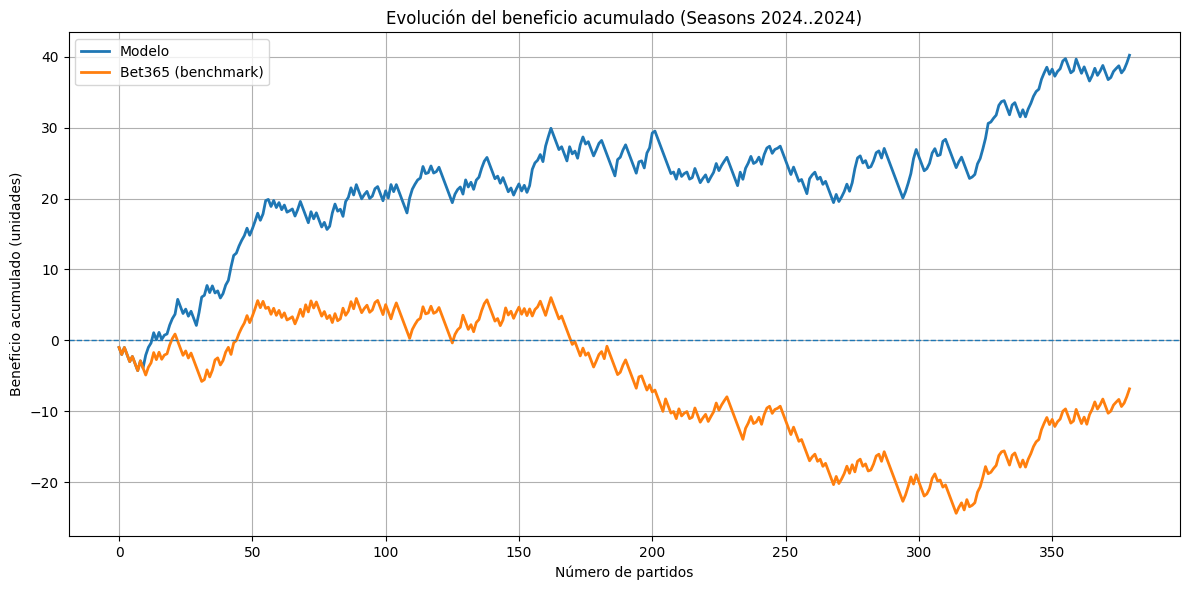

In [ ]:
tabla = plot_cumulative_profit_model_vs_bet365(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True, meta_df=df_old, stake=1.0)

# **Modelos por fase de la temporada**

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/TFM/data/processed/df_final.parquet'

df = pd.read_parquet(file_path)

df.head()

,Date,FTR,B365H,B365D,B365A,h_elo,a_elo,Season,h_avg_age,h_value_mio,...,pimp1,pimpx,pimp2,fase_temporada,has_xg_data,target,home_playstyle_equilibrado,home_playstyle_ofensivo,away_playstyle_equilibrado,away_playstyle_ofensivo
380,2006-08-26,H,1.57,3.60,6.00,1857.375122,1726.076904,2006,26.5,232.70,...,0.589005,0.256872,0.154123,inicio,0,2,1,0,1,0
381,2006-08-27,D,2.30,3.25,3.00,1701.504761,1723.469849,2006,27.1,41.90,...,0.404145,0.286010,0.309845,inicio,0,1,1,0,1,0
382,2006-08-27,D,1.53,3.80,6.00,1883.077393,1829.429443,2006,25.3,372.20,...,0.603270,0.242896,0.153834,inicio,0,1,1,0,1,0
383,2006-08-27,A,3.10,3.20,2.25,1693.620361,1769.739990,2006,25.9,49.30,...,0.298817,0.289479,0.411704,inicio,0,0,1,0,1,0
384,2006-08-27,A,1.83,3.30,4.33,1756.190308,1762.177246,2006,25.2,71.35,...,0.505771,0.280473,0.213756,inicio,0,0,1,0,1,0


## Modelo INICIO

In [ ]:
df_inicio = df[df['fase_temporada'] == 'inicio']

In [ ]:
drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

In [ ]:
X_inicio = df_inicio.drop(columns=drop_cols)
y_inicio = df_inicio['target']

In [ ]:
X_train_inicio = X_inicio[df_inicio['Season'] <= 2023]
y_train_inicio = y_inicio[df_inicio['Season'] <= 2023]

X_test_inicio = X_inicio[df_inicio['Season'] > 2023]
y_test_inicio = y_inicio[df_inicio['Season'] > 2023]

In [ ]:
X_train_inicio = X_train_inicio.drop(columns=['Season'])
X_test_inicio = X_test_inicio.drop(columns=['Season'])

y_train_inicio = y_train_inicio.drop(columns=['Season'])
y_test_inicio = y_test_inicio.drop(columns=['Season'])

In [ ]:
len(X_train_inicio)

2378

In [ ]:
len(X_test_inicio)

137

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_inicio = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_inicio.fit(X_train_inicio, y_train_inicio)

# Predicciones
y_train_pred_inicio = model_inicio.predict(X_train_inicio)
y_train_proba_inicio = model_inicio.predict_proba(X_train_inicio)
y_test_pred_inicio = model_inicio.predict(X_test_inicio)
y_test_proba_inicio = model_inicio.predict_proba(X_test_inicio)

# Evaluación
print("Logistic Regression multinomial (INICIO):")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_inicio, y_train_pred_inicio))
print("Log Loss:", log_loss(y_train_inicio, y_train_proba_inicio))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_inicio, y_test_pred_inicio))
print("Log Loss:", log_loss(y_test_inicio, y_test_proba_inicio))

Logistic Regression multinomial (INICIO):

=== Train ===
Accuracy: 0.5592935239697224
Log Loss: 0.9367516269785796

=== Test ===
Accuracy: 0.5328467153284672
Log Loss: 0.9592955079897749


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_inicio[['B365H', 'B365D', 'B365A']]
y_bet = df_inicio['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_inicio = accuracy_score(y_bet, bet365_pred)
logloss_inicio = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase inicio):", acc_inicio)
print("Log Loss cuotas (fase inicio):", logloss_inicio)

Accuracy cuotas (fase inicio): 0.5339960238568588
Log Loss cuotas (fase inicio): 0.9689888955708615


## Modelo MITAD

In [ ]:
df_mitad = df[df['fase_temporada'] == 'mitad']

drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

X_mitad = df_mitad.drop(columns=drop_cols)
y_mitad = df_mitad['target']

X_train_mitad = X_mitad[df_mitad['Season'] <= 2023]
y_train_mitad = y_mitad[df_mitad['Season'] <= 2023]

X_test_mitad = X_mitad[df_mitad['Season'] > 2023]
y_test_mitad = y_mitad[df_mitad['Season'] > 2023]

X_train_mitad = X_train_mitad.drop(columns=['Season'])
X_test_mitad = X_test_mitad.drop(columns=['Season'])

y_train_mitad = y_train_mitad.drop(columns=['Season'])
y_test_mitad = y_test_mitad.drop(columns=['Season'])

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_mitad = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_mitad.fit(X_train_mitad, y_train_mitad)

# Predicciones
y_train_pred_mitad = model_mitad.predict(X_train_mitad)
y_train_proba_mitad = model_mitad.predict_proba(X_train_mitad)
y_test_pred_mitad = model_mitad.predict(X_test_mitad)
y_test_proba_mitad = model_mitad.predict_proba(X_test_mitad)

# Evaluación
print("Logistic Regression multinomial (MITAD):")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_mitad, y_train_pred_mitad))
print("Log Loss:", log_loss(y_train_mitad, y_train_proba_mitad))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_mitad, y_test_pred_mitad))
print("Log Loss:", log_loss(y_test_mitad, y_test_proba_mitad))

Logistic Regression multinomial (MITAD):

=== Train ===
Accuracy: 0.5556989247311828
Log Loss: 0.93106415341006

=== Test ===
Accuracy: 0.5
Log Loss: 1.0832087367408858


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_mitad[['B365H', 'B365D', 'B365A']]
y_bet = df_mitad['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_mitad = accuracy_score(y_bet, bet365_pred)
logloss_mitad = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase mitad):", acc_mitad)
print("Log Loss cuotas (fase mitad):", logloss_mitad)

Accuracy cuotas (fase mitad): 0.5369237046103631
Log Loss cuotas (fase mitad): 0.9664413990317429


## Modelo FINAL

In [ ]:
df_final = df[df['fase_temporada'] == 'final']

drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

X_final = df_final.drop(columns=drop_cols)
y_final = df_final['target']

X_train_final = X_final[df_final['Season'] <= 2023]
y_train_final = y_final[df_final['Season'] <= 2023]

X_test_final = X_final[df_final['Season'] > 2023]
y_test_final = y_final[df_final['Season'] > 2023]

X_train_final = X_train_final.drop(columns=['Season'])
X_test_final = X_test_final.drop(columns=['Season'])

y_train_final = y_train_final.drop(columns=['Season'])
y_test_final = y_test_final.drop(columns=['Season'])

len(X_train_final)

len(X_test_final)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_final = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_final.fit(X_train_final, y_train_final)

# Predicciones
y_train_pred_final = model_final.predict(X_train_final)
y_train_proba_final = model_final.predict_proba(X_train_final)
y_test_pred_final = model_final.predict(X_test_final)
y_test_proba_final = model_final.predict_proba(X_test_final)

# Evaluación
print("Logistic Regression multinomial:")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_final, y_train_pred_final))
print("Log Loss:", log_loss(y_train_final, y_train_proba_final))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_final, y_test_pred_final))
print("Log Loss:", log_loss(y_test_final, y_test_proba_final))

Logistic Regression multinomial:

=== Train ===
Accuracy: 0.5694899391670566
Log Loss: 0.9104440710091384

=== Test ===
Accuracy: 0.5042735042735043
Log Loss: 0.9755798208990906


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_final[['B365H', 'B365D', 'B365A']]
y_bet = df_final['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_final = accuracy_score(y_bet, bet365_pred)
logloss_final = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase final):", acc_final)
print("Log Loss cuotas (fase final):", logloss_final)

Accuracy cuotas (fase final): 0.5607808340727596
Log Loss cuotas (fase final): 0.9427790451312839


In [ ]:
!jupyter nbconvert --to html /content/MODELOS.ipynb

[NbConvertApp] Converting notebook /content/MODELOS.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1267860 bytes to /content/MODELOS.html
